# 蠟燭線回測
### 初始資料拿取

In [27]:
import numpy as np
import pandas as pd
from talib import abstract
from finlab.data import Data

%matplotlib inline

data = Data()

signal = data.talib('CDLTRISTAR')

close = data.get_adj('收盤價')
open_ = data.get_adj('開盤價')

In [20]:
df = pd.read_csv('TXF\TXF.txt', sep=",")
df['DateTime'] = df.Date + ' ' + df.Time
df = df[['DateTime', 'Open', 'Close']]

In [22]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [26]:
sma1 = talib.SMA(df.Close, timeperiod=60)

array([   0,  100, -100])

In [29]:
sids

Index(['0015', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057',
       '0058'],
      dtype='object', name='stock_id')

### 計算買入時間

<AxesSubplot:xlabel='date'>

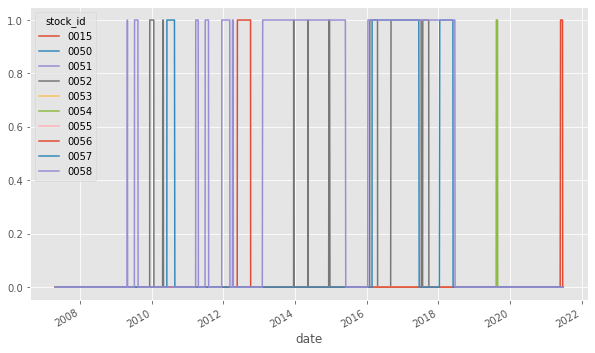

In [33]:
buy = (signal > 0)
sell = close < close.rolling(20).mean()
    
hold = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
hold[buy] = 1
hold[sell] = 0
hold.ffill(inplace=True)
hold.fillna(0, inplace=True)
hold = hold.shift()

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

In [31]:
buy.head()

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058
date,,,,,,,,,,
2007-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 計算報酬率

<AxesSubplot:xlabel='date'>

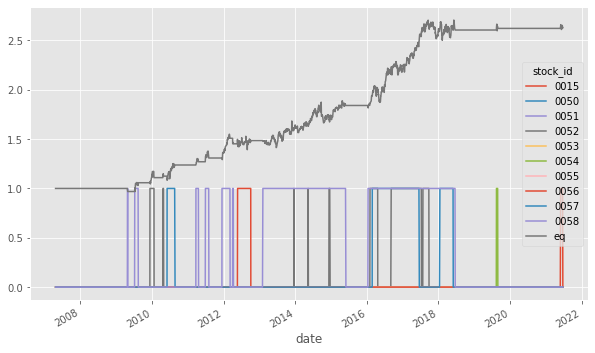

In [34]:
import matplotlib.pyplot as plt

gain = open_.shift(-1).ffill()[sids] / open_.ffill()[sids]
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()

draw_df = hold.copy()
draw_df['eq'] = eq

draw_df.plot()

In [37]:
gain[hold == 1].tail()

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058
date,,,,,,,,,,
2021-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.009518,NaN,NaN
2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995714,NaN,NaN
2021-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995696,NaN,NaN
2021-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 不要每天都rebalance

2.3126964791497087

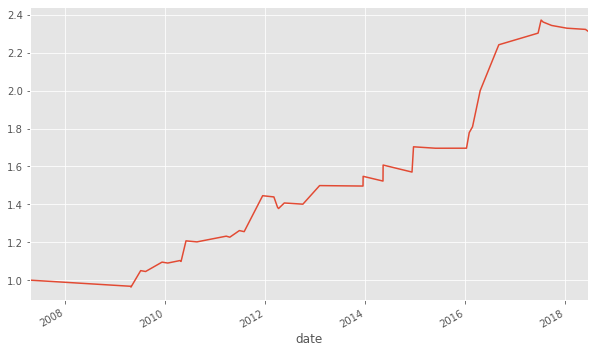

In [5]:
rebalance = (hold.diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0]
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1])
rebalance_gain.index = rebalance_hold.index

# 手續費
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff()
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().sum(axis=1)


eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod()
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [7]:
import pickle
pickle.dump(eq, open('return_history.pkl', 'wb'))